In [169]:
from skimage import io,transform, util
import numpy as np
import stackview
import pystackreg

from os import path
from glob import glob
from pystackreg import StackReg
from skimage.transform import EuclideanTransform, warp

from imageUtils import find_most_likely_z_slice_using_CC, z_translate_and_pad
import pyvista as pv
pv.set_jupyter_backend('trame')

In [170]:
dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Palbo senescence pilot/Julie Charlotte Nielsen\'s files - 11-01-2025 H2B FUCCI Palbo/M1 cage 5971/Left ear/R2'

day_folder = '3. Day 3'

# Check if 'R_reg_reg' and 'R_shg_reg_reg' exist:
# if path.exists(path.join(dirname,day_folder,'R_reg_Reg.tif'))

# 0. Load channel TIFs

In [171]:
B = io.imread(path.join(dirname,day_folder,'B_reg.tif'))
G = io.imread(path.join(dirname,day_folder,'G_reg.tif'))
R = io.imread(path.join(dirname,day_folder,'R_reg.tif'))
R_shg = io.imread(path.join(dirname,day_folder,'R_shg_reg.tif'))

dx = 0.2919921875
dz = 0.7
scale = [dz/dx,1,1]

In [172]:
slicer = stackview.slice(R,zoom_factor=0.5)
slicer

# Cross correlation 2.5-D method

In [173]:
idx_Z_reference = 25
idx_Z_target = find_most_likely_z_slice_using_CC(B[idx_Z_reference,...], R)

print(f'Z slice on target stsack: {idx_Z_target}')


Cross correlation started
Z slice on target stsack: 8


In [174]:
reference = B[idx_Z_reference]
target = R[idx_Z_target]
stackview.side_by_side(reference,target,zoom_factor=0.5)

side_by_side


In [175]:
# Turn ON or OFF XY-registration if the above image isn't aligned well
XY_reg = True

In [176]:
#NB: Here, move the R channel wrt the B channel
if XY_reg:
    print('StackReg + transform')
    sr = StackReg(StackReg.RIGID_BODY)
    T = sr.register(reference/reference.max(),target/target.max()) #Obtain the transformation matrices
    T = EuclideanTransform(T)
    print(f'XYreg result: translation = {T.translation}; rotation = {np.rad2deg(T.rotation)} degrees')
    R_transformed = np.zeros_like(R).astype(float)
    R_shg_transformed = np.zeros_like(R).astype(float)
    for i, R_slice in enumerate(R):
        R_transformed[i,...] = warp(R_slice,T)
        R_shg_transformed[i,...] = warp(R_shg[i,...],T)
else:
    R_transformed = R.copy()
    R_shg_transformed = R_shg.copy()
    
# z-pad
print(f'Target image shape pre-padding: {R_transformed.shape}')
R_padded = z_translate_and_pad(B,R_transformed,idx_Z_reference,idx_Z_target)
print(f'Target image shape pre-padding: {R_padded.shape}')
print(f'Reference image shape: {B.shape}')

R_shg_padded = z_translate_and_pad(B,R_shg_transformed,idx_Z_reference,idx_Z_target)

R_padded = util.img_as_uint(R_padded/R_padded.max())
R_shg_padded = util.img_as_uint(R_shg_padded/R_shg_padded.max())

StackReg + transform
XYreg result: translation = [-0.72639887  1.06507339]; rotation = -0.03490303053597673 degrees
Target image shape pre-padding: (43, 1024, 1024)
Target image shape pre-padding: (58, 1024, 1024)
Reference image shape: (58, 1024, 1024)


In [177]:
stackview.side_by_side(B[idx_Z_reference,...],R_padded[idx_Z_reference,...],zoom_factor=0.5)


side_by_side


In [178]:
io.imsave(path.join(dirname,day_folder,'R_reg_reg.tif'),R_padded)
io.imsave(path.join(dirname,day_folder,'R_shg_reg_reg.tif'),R_shg_padded)

# BM mesh reconstruction and 2D registration, followed by XZ/XY registration (not working yet)

In [6]:
G_height_image = io.imread(path.join(dirname,'G_height_image.tif'))
R_height_image = io.imread(path.join(dirname,'R_shg_height_image.tif'))
stackview.slice(G_height_image,zoom_factor=0.5)

In [8]:
stackview.slice(R_height_image,zoom_factor=0.5)

In [32]:
X_trim = slice(200,800)
Y_trim = slice(200,800)
dz = 0.7
dx= 0.29

In [33]:
# Mesh reconstruction

from measurements import get_mesh_from_bm_image
R_mesh = get_mesh_from_bm_image(R_height_image[:,Y_trim,X_trim],spacing=[dz,dx,dx],decimation_factor=30)
G_mesh = get_mesh_from_bm_image(G_height_image[:,Y_trim,X_trim],spacing=[dz,dx,dx],decimation_factor=30)


In [34]:
R_mesh

<trimesh.Trimesh(vertices.shape=(12000, 3), faces.shape=(23901, 3))>

In [35]:
from measurements import get_tissue_curvatures

curvature_G = get_tissue_curvatures(G_mesh)
curvature_R = get_tissue_curvatures(R_mesh)


In [36]:
ZZ,XX,_ = G_height_image.shape
# Match the 'pixel grid' to the 'microns grid' used by Trimesh
pixel_gridX = np.arange(XX)
# gridY,gridX = np.meshgrid()

micron_Xmin,micron_Xmax = G_mesh.vertices[:,1].min(),G_mesh.vertices[:,1].max()
micron_Ymin,micron_Ymax = G_mesh.vertices[:,0].min(),G_mesh.vertices[:,0].max()

Ngrid = XX
micron_gridX = np.linspace(0,micron_Xmax,Ngrid)
micron_gridY = np.linspace(0,micron_Ymax,Ngrid)
micron_gridXX,micron_gridYY = np.meshgrid( micron_gridX, micron_gridY)
Ngrid


1024

(34953,)

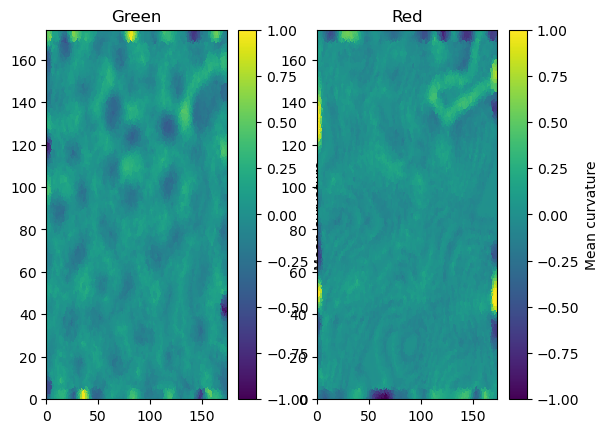

In [37]:
from scipy.interpolate import NearestNDInterpolator
import matplotlib.pyplot as plt

interp = NearestNDInterpolator(list(zip(G_mesh.vertices[:,0], G_mesh.vertices[:,1])), curvature_G[0])
plt.subplot(1,2,1)
plt.title('Green')
G_curv_grid = interp( micron_gridXX,micron_gridYY )
plt.pcolor(micron_gridXX,micron_gridY,G_curv_grid)
plt.clim([-1,1])
plt.colorbar(label='Mean curvature')

interp = NearestNDInterpolator(list(zip(R_mesh.vertices[:,0], R_mesh.vertices[:,1])), curvature_R[0])
plt.subplot(1,2,2)
plt.title('Red')
R_curv_grid = interp( micron_gridXX,micron_gridYY )
plt.pcolor(micron_gridXX,micron_gridYY,R_curv_grid)
plt.clim([-1,1])

plt.colorbar(label='Mean curvature')